## Import

In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

## Read Data

In [2]:
# 구매 데이터 읽기
purchase = pd.read_csv('../data/DC_구매내역정보.csv', parse_dates=['구매일자'], encoding='cp949')
print('데이터 크기:', purchase.shape)

데이터 크기: (98192, 13)


In [3]:
purchase.sample(5)

,ID,상품대분류명,상품중분류명,구매지역,구매일자,구매수량,구매금액,취소여부,증정상품,거래ID,매장ID,환불기간,구매거래ID
86301,882284269,생활잡화,주방용품,서울 동대문구,2014-08-26 16:00:00,1,76000,0,0,35615,하이마트,NaN,NaN
85909,877256654,식품,음료,부산 부산진구,2014-05-08 16:00:00,1,3000,0,0,35440,백화점,NaN,NaN
65365,679339798,레포츠,스포츠용품/의류,부산 부산진구,2014-11-06 17:00:00,-162,-144000,1,0,27260,백화점,5.0,27259.0
49157,506047370,가전제품,생활가전,경기 안산시,2014-12-23 15:00:00,1,879000,0,0,20350,하이마트,NaN,NaN
17470,175723513,의류잡화,여성용의류-정장류,서울 중구,2014-05-23 16:00:00,1,882000,0,0,7319,백화점,NaN,NaN


## $\blacktriangleright$ RFM 변수 생성
- Recency(최근 구매일), Frequency(구매빈도), Monetary(구매금액)의 약자로, 고객 평가와 세분화를 위한 기법 중 하나이다.<br>
  $\bullet$ Recency: 최근에 상품이나 서비스를 구매한 고객은 새로운 마케팅에 잠재적으로 더 높은 관심을 가질 수 있음을 반영한 지표<br>
  $\bullet$ Frequency: 자주 구매하는 고객은 브랜드에 대한 충성도가 높을 가능성이 있음을 반영한 지표<br>
  $\bullet$ Monetary: 높은 구매 금액을 가진 고객은 기업의 수익에 더 많은 기여를 할 수 있음을 반영한 지표
- 고객의 행동 패턴을 분석하고 고객 세분화 및 군집별 가치 있는 정보를 도출해 효과적인 `타켓` 마케팅 전략을 수립하고 개선할 수 있다.

In [4]:
department = purchase.query('매장ID=="백화점"')
departmentfeature = pd.concat([department.groupby('ID')['구매일자'].agg(lambda x: (pd.to_datetime("2015-01-01")-x.max()).days).rename('recency'),
                               department.groupby('ID')['거래ID'].nunique().rename('frequency'),
                               department.groupby('ID')['구매금액'].sum().rename('monetary')], axis=1)
departmentfeature.shape

(3214, 3)

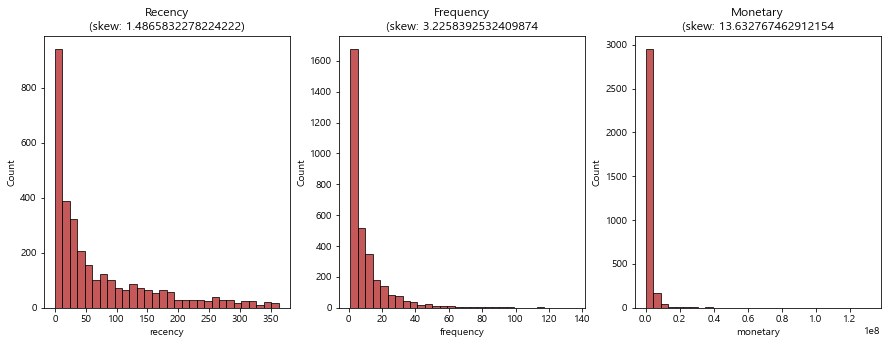

In [5]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(departmentfeature['recency'], bins=30, color='firebrick', ax=ax[0])
sns.histplot(departmentfeature['frequency'], bins=30, color='firebrick', ax=ax[1])
sns.histplot(departmentfeature['monetary'], bins=30, color='firebrick', ax=ax[2])
ax[0].set_title(f"Recency\n(skew: {departmentfeature.recency.skew()})")
ax[1].set_title(f"Frequency\n(skew: {departmentfeature.frequency.skew()}")
ax[2].set_title(f"Monetary\n(skew: {departmentfeature.monetary.skew()}")
plt.show()

In [6]:
himart = purchase.query('매장ID=="하이마트"')
himartfeature = pd.concat([himart.groupby('ID')['구매일자'].agg(lambda x: (pd.to_datetime("2015-01-01") - x.max()).days).rename('recency'),
                           himart.groupby('ID')['거래ID'].nunique().rename('frequency'),
                           himart.groupby('ID')['구매금액'].sum().rename('monetary')], axis=1)
himartfeature.shape

(2785, 3)

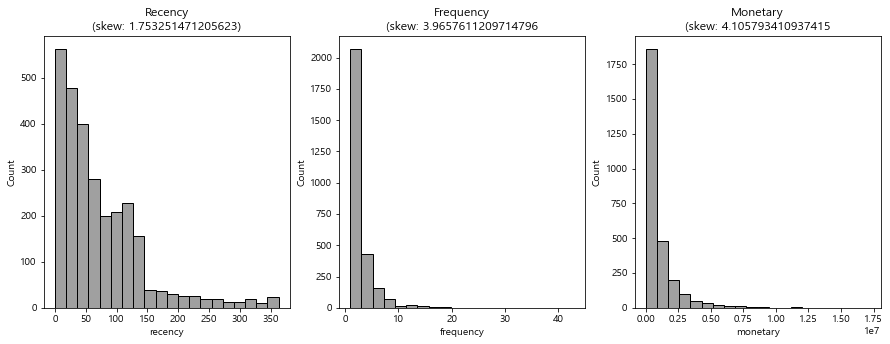

In [7]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(himartfeature['recency'], bins=20, color='gray', ax=ax[0])
sns.histplot(himartfeature['frequency'], bins=20, color='gray', ax=ax[1])
sns.histplot(himartfeature['monetary'], bins=20, color='gray', ax=ax[2])
ax[0].set_title(f"Recency\n(skew: {himartfeature.recency.skew()})")
ax[1].set_title(f"Frequency\n(skew: {himartfeature.frequency.skew()}")
ax[2].set_title(f"Monetary\n(skew: {himartfeature.monetary.skew()}")
plt.show()

## $\blacktriangleright$ 이상치 제거
- 방법1) IQR box를 사용해 데이터를 제거하면 백화점 고객의 29%, 하이마트 고객의 20%가 제거된다.
- 방법2) 정규분포로 변환하고 Zscore를 사용해 제거한다.<br>
  $\bullet$ np.sqrt로 변환할 경우 백화점과 하이마트 모두 고객의 3% 제거된다. 그러나 변환한 분포가 여전히 왼쪽에 치우친 편이다.<br>
  $\bullet$ log나 boxcox 변환을 위해선 데이터에 +1을 해야 하며 백화점과 하이마트 모두 1%채 제거되지 않는다. 극단값만 제거된다.<br>
  $\bullet$ BoxCox의 왜도가 

In [8]:
# 로그 변환 시 0은 inf가 나옴으로 1을 더하고 변환한다. Recency는 작으면 좋음으로 -1을 곱한다.
df_log = pd.concat([np.log(departmentfeature['recency']+1) * -1,
                    np.log(departmentfeature['frequency']),
                    np.log(departmentfeature['monetary']+1)], axis=1)
hm_log = pd.concat([np.log(himartfeature['recency']+1) * -1,
                    np.log(himartfeature['frequency']),
                    np.log(himartfeature['monetary']+1)], axis=1)
print(f'백화점 skew값: {df_log.recency.skew()},{df_log.frequency.skew()},{df_log.monetary.skew()}')
print(f'하이마트 skew값: {hm_log.recency.skew()},{hm_log.frequency.skew()},{hm_log.monetary.skew()}')

백화점 skew값: 0.38750596445247637,0.21781981678753054,-0.4498245969488774
하이마트 skew값: 0.8799630945695387,0.4497907665076449,-0.8850706282058711


In [9]:
# 제곱근 변환 후 Recency는 작으면 좋음으로 -1을 곱한다.
df_sqrt = pd.concat([np.sqrt(departmentfeature['recency']) * -1,
                     np.sqrt(departmentfeature['frequency']),
                     np.sqrt(departmentfeature['monetary'])], axis=1)
hm_sqrt = pd.concat([np.sqrt(himartfeature['recency']) * -1,
                     np.sqrt(himartfeature['frequency']),
                     np.sqrt(himartfeature['monetary'])], axis=1)
print(f'백화점 skew값: {df_sqrt.recency.skew()},{df_sqrt.frequency.skew()},{df_sqrt.monetary.skew()}')
print(f'하이마트 skew값: {hm_sqrt.recency.skew()},{hm_sqrt.frequency.skew()},{hm_sqrt.monetary.skew()}')

백화점 skew값: -0.6559162165271614,1.4606072307895839,2.7762021773174674
하이마트 skew값: -0.5162883974656866,1.4965097713778723,1.4857104811927713


In [10]:
# 양수만 box-cox변환을 할 수 있음으로 recency, monetary는 모두 1을 더 해 분포를 밀어주고 변환한다.
# Recency는 작으면 좋음으로 -1을 곱해준다.
df_bc = pd.concat([pd.Series(boxcox(departmentfeature['recency']+1)[0] * -1, index=departmentfeature.index, name='recency'),
                   pd.Series(boxcox(departmentfeature['frequency'])[0], index=departmentfeature.index, name='frequency'),
                   pd.Series(boxcox(departmentfeature['monetary']+1)[0], index=departmentfeature.index, name='monetary')], axis=1)
hm_bc = pd.concat([pd.Series(boxcox(himartfeature['recency']+1)[0] * -1, index=himartfeature.index, name='recency'),
                   pd.Series(boxcox(himartfeature['frequency'])[0], index=himartfeature.index, name='frequency'),
                   pd.Series(boxcox(himartfeature['monetary']+1)[0], index=himartfeature.index, name='monetary')], axis=1)
print(f'백화점 skew값: {df_bc.recency.skew()},{df_bc.frequency.skew()},{df_bc.monetary.skew()}')
print(f'하이마트 skew값: {hm_bc.recency.skew()},{hm_bc.frequency.skew()},{hm_bc.monetary.skew()}')

백화점 skew값: 0.05801734901368859,0.03028651952531054,0.0031056443699263685
하이마트 skew값: 0.036429602156180366,0.06423270582988412,-0.0010527293950845017


In [11]:
def remove_zscore(data, threshold=3):
    # 전체가 False여야 함
    z = np.abs(data - np.mean(data)) / np.std(data)
    outlier = data[(z > threshold).sum(axis=1) != 0].index
    return data.drop(outlier)

In [12]:
# 로그 변환 데이터의 이상치를 제거한다.
df_log = remove_zscore(df_log)
hm_log = remove_zscore(hm_log)
print('보존 비율:', df_log.shape[0]/departmentfeature.shape[0])
print('보존 비율:', hm_log.shape[0]/himartfeature.shape[0])

보존 비율: 0.9975108898568762
보존 비율: 0.9820466786355476


In [13]:
# 로그 변환 데이터의 이상치를 제거한다.
df_bc = remove_zscore(df_bc)
hm_bc = remove_zscore(hm_bc)
print('보존 비율:', df_bc.shape[0]/departmentfeature.shape[0])
print('보존 비율:', hm_bc.shape[0]/himartfeature.shape[0])

보존 비율: 0.9975108898568762
보존 비율: 0.9978456014362657


## Save data

In [14]:
pickle.dump((df_log, hm_log, df_bc, hm_bc), open('../data/RFMfeatures.pkl', 'wb'))